In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [2]:
cases = ["sq_mid_nocut_dir","sq_mid_nocut_dir2","sq_mid_nocut_dir3"]
grids = ["lowest", "low", "mid"]
data = []
ncs = []
for c, case in enumerate(cases):
    filepath = str(case) + "/BOUT.dmp.*.nc"

    ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
    dsn = xr.open_dataset("sq_mid_nocut_" + str(grids[c]) + "res.fci.nc")

    # Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
    ds = ds.squeeze(drop=True)
    dsn = dsn.squeeze(drop=True)

    dx = ds["dx"].isel(z=0).values
    # Get rid of existing "x" coordinate, which is just the index values.
    #ds = ds.drop("x")
    #Create a new coordinate, which is length in units of rho_s
    ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

    data.append(ds)
    ncs.append(dsn)

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 46MB
Dimensions:             (x: 68, y: 1, z: 68, t: 201)
Coordinates:
    dx                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dy                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dz                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 544B 0 1 2 3 4 5 6 7 ... 61 62 63 64 65 66 67
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 544B 0.007353 0.02206 ... 0.9779 0.9926
Data variables: (12/52)
    Bxy                 (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G1                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G2                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 172MB
Dimensions:             (x: 132, y: 1, z: 132, t: 201)
Coordinates:
    dx                  (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
    dy                  (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
    dz                  (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 1kB 0 1 2 3 4 5 6 ... 126 127 128 129 130 131
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 1kB 0.003788 0.01136 ... 0.9886 0.9962
Data variables: (12/52)
    Bxy                 (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
    G1                  (x, y, z) float64 139kB dask.array<chunksize=(132, 1, 132), meta=np.ndarray>
    G2                  (x, y, z) float64 139kB dask.array<

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [3]:

# Inputs assumed:
# bdy_pts: (Nb, 2) array, columns [R_b, Z_b] for boundary intercepts (BI)
# img_pts: (Nb, 2) array, columns [R_ip, Z_ip] for image points (inside fluid)
# dist_n:  (Nb,) array, distance along normal from BI to IP (physical coordinates)
# x_spl, z_spl: splines such that x_spl.ev(R,Z), z_spl.ev(R,Z) give computational coords
# x, z: 1D arrays of computational grid coords (same indexing as dens)
# dens: array with shape (nt, nx, nz) in (t,x,z) with indexing='ij'
# t_array: 1D array of physical times
# analytic_density(R, Z, t): function returning analytic density at given physical coords

def neumann_boundary_error_at_time(bdy_pts, img_pts, normals, spl):
    # --- 1. Physical boundary & image points ---
    Rb = bdy_pts[:, 0]
    Zb = bdy_pts[:, 1]
    Rip = img_pts[:, 0]
    Zip = img_pts[:, 1]

    # --- 2. Map to computational coordinates (x,z) ---
    spl_e = spl #RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[k,:,:], kx=1, ky=1)
    n_num_b  = spl_e.ev(Rb,  Zb)
    n_num_ip  = spl_e.ev(Rip, Zip)

    # --- 4. Numerical normal derivative (one-sided) ---
    # du/dn ≈ (u(IP) - u(BI)) / dist_n
    du_dn_num = (n_num_ip - n_num_b) / np.hypot(normals[:,0], normals[:,1])

    # --- 5. Analytic normal derivative (same stencil) ---
    #t = t_array[t_index]

    #n_ana_b  = analytic_density(Rb,  Zb,  t)
    #n_ana_ip = analytic_density(Rip, Zip, t)

    du_dn_ana = 0 #(n_ana_ip - n_ana_b) / normals #TODO: Get BC condition?

    # If Neumann BC is zero-flux, du_dn_ana should be ~0; you can
    # just look at |du_dn_num|. Otherwise compare num vs ana:

    err = du_dn_num - du_dn_ana

    # L2 and Linf norms along the boundary
    L2_bnd   = np.sqrt(np.nanmean(err**2))
    Linf_bnd = np.nanmax(np.abs(err))

    # Relative norms (guard against zero analytic derivative)
    denom_L2   = max(np.nanmean(np.abs(du_dn_ana)), 1e-14)
    denom_Linf = max(np.nanmax(np.abs(du_dn_ana)), 1e-14)

    L2_rel   = L2_bnd   / denom_L2
    Linf_rel = Linf_bnd / denom_Linf

    return {
        "du_dn_num": du_dn_num,
        "du_dn_ana": du_dn_ana,
        "err": err,
        "L2_bnd": L2_bnd,
        "Linf_bnd": Linf_bnd,
        "L2_rel": L2_rel,
        "Linf_rel": Linf_rel,
    }

def dirichlet_boundary_error_at_time(bdy_pts, spl):
    # --- 1. Physical boundary & image points ---
    Rb = bdy_pts[:, 0]
    Zb = bdy_pts[:, 1]

    # --- 2. Map to computational coordinates (x,z) ---
    #spl = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[k,:,:], kx=1, ky=1)
    n_num_b  = spl.ev(Rb,  Zb)

    # --- 5. Analytic normal derivative (same stencil) ---
    #t = t_array[t_index]

    #n_ana_b  = analytic_density(Rb,  Zb,  t)
    #n_ana_ip = analytic_density(Rip, Zip, t)

    n_ana = 0 #(n_ana_ip - n_ana_b) / normals #TODO: Get BC condition?

    # If Neumann BC is zero-flux, du_dn_ana should be ~0; you can
    # just look at |du_dn_num|. Otherwise compare num vs ana:

    err = n_num_b - n_ana

    # L2 and Linf norms along the boundary
    L2_bnd   = np.sqrt(np.nanmean(err**2))
    Linf_bnd = np.nanmax(np.abs(err))

    # Relative norms (guard against zero analytic derivative)
    denom_L2   = max(np.nanmean(np.abs(n_ana)), 1e-14)
    denom_Linf = max(np.nanmax(np.abs(n_ana)), 1e-14)

    L2_rel   = L2_bnd   / denom_L2
    Linf_rel = Linf_bnd / denom_Linf

    return {
        "n_num_b": n_num_b,
        "n_ana": n_ana,
        "err": err,
        "L2_bnd": L2_bnd,
        "Linf_bnd": Linf_bnd,
        "L2_rel": L2_rel,
        "Linf_rel": Linf_rel,
    }

In [4]:
Lbs = np.array([1.76171875, 1.755859375, 1.7529296875])
Rbs = np.array([3.23828125, 3.244140625, 3.2470703125])
Bbs = np.array([-0.7610294117647058, -0.7556818181818182, -0.7528846153846154])
Tbs = -Bbs
D = 1.0
m = 1.0
n = 1.0
timestep_for_errs_early = 10
timestep_for_errs_late = 100

w_unit = 95788333.030660808 #Omega_ci
t_unit = 1/w_unit

denses = []
dens_trues = []
masks = []
ghost_masks = []
dens_diffs = []
num_errs = []
l2_errs = []
linf_errs = []

lbda_errs = np.zeros_like(Lbs)
l2_bd_err = []
linf_bd_err = []
mass_changes = []
mass_errs = []

for d, dat in enumerate(data):
    print("Reading data for run: ", d)
    dens = dat["Nh+"]
    src = dat["SNh+"]
    dens_true = dens.copy()

    mask = ncs[d]["in_mask"]
    #vols = ncs[d]["vol_frac"]
    ghost_id = ncs[d]["ghost_id"].values
    ghost_mask = (ghost_id >= 0).astype(bool)
    full_mask = ghost_mask | mask.astype(bool)
    #vols = np.where(mask, vols, 0)
    gst_pts = ncs[d]["ghost_pts"].values
    bdy_pts = ncs[d]["bndry_pts"].values
    img_pts = ncs[d]["image_pts"].values
    normals = ncs[d]["normals"].values
    is_plasma = ncs[d]["is_plasma"].values
    Rarr = ncs[d]["R"].values
    Zarr = ncs[d]["Z"].values

    spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
    spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:],  kx=1, ky=1)

    nx = 64*(2**(d))
    nz = nx + 4
    dx = np.float64(1.0) / np.float64(nx)
    dz = np.float64(1.0) / np.float64(nz)

    # Centers in x; faces/nodes in z if that's your convention
    x = (np.arange(nx, dtype=np.float64) + 0.5) * dx     # centered x
    z = (np.arange(nz, dtype=np.float64)) * dz           # unshifted z

    ghosts_lo_x = x[0]  - dx*np.arange(2, 0, -1)
    ghosts_hi_x = x[-1] + dx*np.arange(1, 2+1)
    x = np.concatenate((ghosts_lo_x, x, ghosts_hi_x))
    xx,zz = np.meshgrid(x,z,indexing='ij')

    Lb, Rb, Bb, Tb = Lbs[d], Rbs[d], Bbs[d], Tbs[d]

    #Use physical grid values to map R,Z boundary to x,z (i.e. ignore ghosts)
    R_min, R_max = ncs[d]["R"].values[2,0], ncs[d]["R"].values[-3,0]
    Z_min, Z_max = ncs[d]["Z"].values[0,0], ncs[d]["Z"].values[0,-1]
    dR = ncs[d]["R"].values[1,0] - ncs[d]["R"].values[0,0]
    dZ = ncs[d]["Z"].values[0,1] - ncs[d]["Z"].values[0,0]
    xL = x[2] + (Lb - R_min) * (x[-3] - x[2]) / (R_max - R_min)
    xR = x[2] + (Rb - R_min) * (x[-3] - x[2]) / (R_max - R_min)
    zB = z[0] + (Bb - Z_min) * (z[-1] - z[0]) / (Z_max - Z_min)
    zT = z[0] + (Tb - Z_min) * (z[-1] - z[0]) / (Z_max - Z_min)

    Lx = xR - xL
    Lz = zT - zB
    xi   = (x - xL)/ Lx
    zeta = (z - zB)/ Lz
    lbda = (m*np.pi/(Rb-Lb))**2 + (n*np.pi/(Tb-Bb))**2

    xxi, zzeta = np.meshgrid(xi,zeta,indexing='ij',copy=False)
    t64 = np.asarray(dat["t_array"].values, dtype=np.float64) # 1D time
    t_norm = t64*t_unit

    print("left, right: ", xL, zB)
    print("Box size: ", Lx, Lz)

    #Compare simulation lambda to analytic value:
    #Use density near the center, which is always 1...
    n0 = dens.values[0,(nx+4)//2-1,nz//2-1]
    n1 = dens.values[1,(nx+4)//2-1,nz//2-1]
    dt = t_norm[1] - t_norm[0]
    ratio = n1 / n0
    lambda_eff = -np.log(ratio) / (D * dt)
    #print("Effective lambda from simulation after one timestep:", lambda_eff)
    #print("Analytic lambda:", lbda)
    lbda_errs[d] = 100*np.abs((lambda_eff - lbda))/lbda
    #print("Percent error:", lbda_errs[d])

    spatial = np.sin(m * np.pi * xxi) * np.sin(n * np.pi * zzeta)
    temp = np.exp(-D * lbda * t_norm)

    dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]

    denses.append(dens)
    dens_trues.append(dens_true)
    masks.append(mask)
    ghost_masks.append(ghost_mask)

    # Example usage:
    res = dirichlet_boundary_error_at_time(bdy_pts, spl_e)
    l2_bd_err.append(res["L2_bnd"])
    linf_bd_err.append(res["Linf_bnd"])

    M0 = (dens.where(mask)*dR*dZ)[0,:,:].sum().values
    M1 = (dens.where(mask)*dR*dZ)[10,:,:].sum().values
    M2 = (dens.where(mask)*dR*dZ)[100,:,:].sum().values
    M3 = (dens.where(mask)*dR*dZ)[-1,:,:].sum().values
    #print(M0, M1, M2, M3)
    mass_change = M3-M0
    mass_changes.append(mass_change)
    mass_errs.append(np.abs(mass_change)/M0)

    #Get L2 error
    N_valid = np.sum(mask)
    dens_diff = np.abs(dens.where(mask)-dens_true.where(mask))
    linf_err_t = np.max(dens_diff)
    l2_err_t = np.sqrt(np.sum((dens_diff**2), axis=(1, 2)) / N_valid)
    dens_diffs.append(dens_diff)
    l2_errs.append(l2_err_t.values)
    linf_errs.append(linf_err_t.values)

    init_dens_diff = dens_diff[0,:,:]
    mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
    nerrs = int(mask2.sum().compute())
    num_errs.append(nerrs)

print('\n')
print("Eigenmode rel. err.: ", lbda_errs[0], lbda_errs[1], lbda_errs[2])
print("Eigenmode rel. err. convergence: ", lbda_errs[0]/lbda_errs[1], lbda_errs[1]/lbda_errs[2])

print('\n')
print("Mass change: ", mass_changes[0], mass_changes[1], mass_changes[2])
print("Mass errs: ", mass_errs[0], mass_errs[1], mass_errs[2])

print('\n')
print("L2 Bdy Err: ", l2_bd_err[0], l2_bd_err[1], l2_bd_err[2])
print("L2 Bdy Err convergence: ", l2_bd_err[0]/l2_bd_err[1], l2_bd_err[1]/l2_bd_err[2])

print('\n')
print("Linf Bdy Err: ", linf_bd_err[0], linf_bd_err[1], linf_bd_err[2])
print("Linf Bdy Err. convergence: ", linf_bd_err[0]/linf_bd_err[1], linf_bd_err[1]/linf_bd_err[2])

print('\n')
print("Cells different than analytic initial value: ", num_errs[0], num_errs[1], num_errs[2])

print('\n')
print("Linf errs: ", linf_errs[0], linf_errs[1], linf_errs[2])
print("Linf convergence: ", linf_errs[0]/linf_errs[1], linf_errs[1]/linf_errs[2])

print('\n')
print("L2 max errs: ", np.max(l2_errs[0]), np.max(l2_errs[1]), np.max(l2_errs[2]))
print("L2 final errs: ", l2_errs[0][-1], l2_errs[1][-1], l2_errs[2][-1])
print("L2 max convergence: ", np.max(l2_errs[0])/np.max(l2_errs[1]), np.max(l2_errs[1])/np.max(l2_errs[2]))


Reading data for run:  0
left, right:  0.25390625 0.2463235294117647
Box size:  0.4921875 0.5073529411764703
Reading data for run:  1
left, right:  0.251953125 0.24810606060606058
Box size:  0.49609375 0.5037878787878788
Reading data for run:  2
left, right:  0.2509765625 0.24903846153846154
Box size:  0.498046875 0.5019230769230768


Eigenmode rel. err.:  0.07620649062078767 0.019510566079096042 0.004945465124269701
Eigenmode rel. err. convergence:  3.9059087425677834 3.945142790179352


Mass change:  -0.9109208129127743 -0.9115694270835943 -0.9117374572957666
Mass errs:  0.9998954581606528 0.9998949071466556 0.9998947557288238


L2 Bdy Err:  7.270994887245225e-05 1.311955636373497e-05 2.3438290569880977e-06
L2 Bdy Err convergence:  5.542104234060599 5.597488573076254


Linf Bdy Err:  0.00040260828290854906 0.00010387055370514897 2.6377917624739142e-05
Linf Bdy Err. convergence:  3.8760579254387024 3.9377844446572827


Cells different than analytic initial value:  0 0 0


Linf errs:  

Nh+ data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


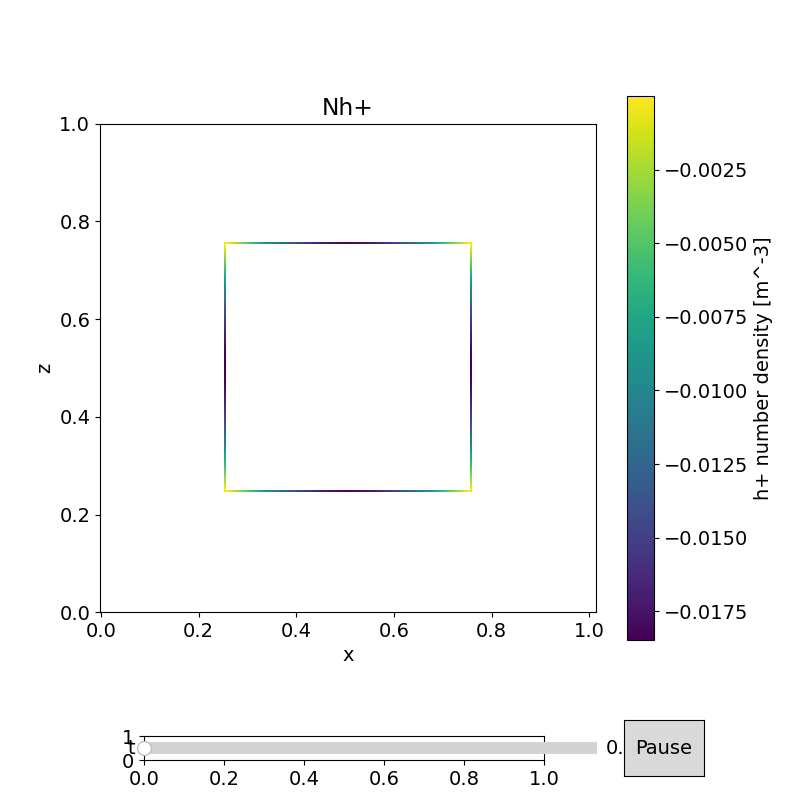

In [5]:
dens.where(ghost_mask).bout.animate2D(aspect='equal')